In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

# Data crunch

In [2]:
# load dataset
dataframe = pd.read_csv('data/final.csv', usecols=['logreturns'])
dataset = dataframe.values
dataset = dataset.astype('float32')

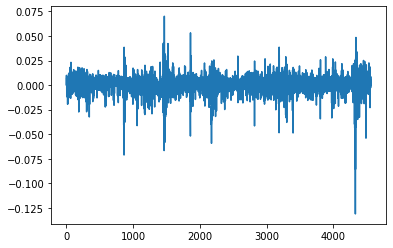

In [3]:
# Visualizing
plt.plot(dataset)

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) - 7)
test_size = len(dataset) - train_size
train =dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

In [6]:
# convert an array of values into a dataset matrix with X=t, Y=t+1
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
# reshape input to be [sample, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # figure out what this does
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Fitting model

In [8]:
# train and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(25))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
143/143 - 2s - loss: 0.1765
Epoch 2/5
143/143 - 0s - loss: 0.0024
Epoch 3/5
143/143 - 0s - loss: 0.0023
Epoch 4/5
143/143 - 0s - loss: 0.0023
Epoch 5/5
143/143 - 0s - loss: 0.0023


In [9]:
# make predictions
forecast_normalized = model.predict(testX)
# inverting the normalization to original scale
forecast = scaler.inverse_transform(forecast_normalized)
testY = scaler.inverse_transform([testY])

# Evaluating

In [14]:
# logreturns to price test
test_df = pd.read_csv('data/final.csv', usecols=['logreturns', 'Close'])

test_df['price_back'] = np.exp(test_df['logreturns']) * test_df['Close'].shift(1)
test_df.tail()



,Close,logreturns,price_back
4559,1249.10,0.005668,1249.10
4560,1245.63,-0.002782,1245.63
4561,1243.38,-0.001808,1243.38
4562,1254.09,0.008577,1254.09
4563,1253.63,-0.000367,1253.63


In [ ]:
def evaluate(n_periods):
    test_ahead = testY[0][:n_periods]
    forecast_ahead = forecast[:,0][:n_periods]

    rmse = math.sqrt(mean_squared_error(test_ahead, forecast_ahead))
    mape = np.mean(np.abs((test_ahead - forecast_ahead) / test_ahead)) * 100
    print(f"RMSE: {round(rmse, 7)}, MAPE: {round(mape, 3)}")

evaluate(1)
evaluate(3)
evaluate(5)


In [ ]:
# Plotting predictions
plt.plot(forecast_ahead, label="forecast")
plt.plot(test_ahead, label="actual")
plt.legend()